# Data preprocessing

This notebook combines the sequence metadata in `Zb_5UTR_MPRA.tsv` with TPM counts in `tpm_data_all_samples` and IVT library counts in `RNA_lib_TPM.tsv`. Then, the following are calculated and saved into `Zb_5UTR_MPRA_preprocessed.tsv.gz`:
- 5'UTR insert ID and metadata
- Columns `TPM_{fraction}_{t}hpf` with the average (geometric mean) TPM across replicates for the total RNA (`{fraction}` is `total`), and the 80S, LMW, and HWM polysome fractions (`{fraction}` is `80S`, `LMW`, and `HMW`), for all timepoints `{t}`.
- Column `TPM_library` with TPMs of the IVT RNA library.
- Columns `log2_TPM_{fraction}_{t}hpf` and `log2_TPM_library` with the logarithm of fraction TPM values.
- Columns `Δlog2_TPM_{t}hpf` with the change in log2 TPM in the total RNA fraction between time `t` and the previous timepoint. For example, `Δlog2_TPM_6hpf` is `log2_TPM_total_6hpf - log2_TPM_total_4hpf` and `Δlog2_TPM_2hpf` is `log2_TPM_total_2hpf - log2_TPM_library`.
- Columns `Δlog2_X_{t}hpf` with the estimated change in log2 RNA abundances in the total RNA fraction between time `t` and the previous timepoint. This is calculated by correcting `Δlog2_TPM_{t}hpf` at every time interval as described in the manuscript.
- Columns `log2_X_{t}hpf` with estimated total RNA abundances at time `{t}`.
- Columns `log2_RRS_{fraction}_{t}hpf` containing log2 RRSs for every fraction and timepoint.
- Columns `MRL_{t}hpf` and `log2_MRL_{t}hpf` containing MRLs for every timepoint, calculated as described in the manuscript.

In [1]:
import os

import numpy
import pandas

import matplotlib
from matplotlib import pyplot
import scipy
import scipy.stats
import seaborn

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'

# Load metadata

In [3]:
# Descriptions of different sublibraries
fraction_list = ['input', '80S', 'LMW', 'HMW']
pol_fraction_list = [f for f in fraction_list if f!='input']
timepoint_list = [2, 4, 6, 10]
replicate_list = ['A', 'B', 'C']

In [4]:
metadata_df = pandas.read_csv(
    'Zb_5UTR_MPRA.tsv',
    sep='\t',
    index_col=0,
    dtype={'index': 'str'},
)
# Drop any RRS columns
metadata_df = metadata_df.loc[:, ~metadata_df.columns.str.startswith('mean_log2_RRS')]

metadata_df

,chr,strand,external_gene_name,utr_length,insert_length,n_uORFs,GC_content,mxfold,index,insert_seq
insert_id,,,,,,,,,,
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,chr9,-,slc35a5,103,103,2,52.427184,23.9,20318,AACGTCAACAAACGATGACGTAGCTTTTGTACGCATGCGTAAGGAT...
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,chr4,-,nrf1,134,134,0,61.940299,35.3,72681,GAGCCCAGGACGCGCGCACTCTGCTGCTCGTTCTTTGTCCTCCATT...
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,chr4,+,ube2h,178,178,1,46.629213,30.1,27446,AGAGGACTACCAGTACTATCCGCTGCGGACAGAAAGTGGAGGGCGA...
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,chr12,+,slc9a3r1a,152,152,0,46.052632,26.1,113092,GATTTGACTTACGGAGTTGCAACACAGTGAAGAGGCGGAGTGCGTG...
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,chr24,-,dap,153,153,1,47.058824,31.8,20320,ATCACGCACCGTTGCCAAACAATGGGCAGGAAAAAGCCACGTTGAC...
...,...,...,...,...,...,...,...,...,...,...
ENSDARG00000025554_ENSDART00000103273_1746_wdr83os_27060,chr11,+,wdr83os,126,126,1,37.301587,22.8,27060,AAGAATCCACACATCTTTGAACGCAGCGGAATTGAGCGTAGTAGAG...
ENSDARG00000103318_ENSDART00000161570_7325_mrpl3_86762,chr19,+,mrpl3,111,111,2,34.234234,12.5,86762,AATGACATTCTGCTACAGGACAAACACGAGACTGACATGATCACTA...
ENSDARG00000036698_ENSDART00000053300_7697_znf865_21263.6,chr19,-,znf865,1305,197,4,31.979695,25.9,21263.6,ACGTGTTAATTGCATGATATTGTAAACCAACTTTTACTTTTTTCTT...


In [5]:
# Column "index" indicates whether sequences come from the same utr
# Split this column to have this information more easily accessible
index_split_cols = metadata_df['index'].str.split('.', expand=True)
metadata_df.insert(loc=metadata_df.shape[1]-1, column='index_base', value=index_split_cols[0].values)
metadata_df.insert(loc=metadata_df.shape[1]-1, column='index_suffix', value=index_split_cols[1].values)
metadata_df

,chr,strand,external_gene_name,utr_length,insert_length,n_uORFs,GC_content,mxfold,index,index_base,index_suffix,insert_seq
insert_id,,,,,,,,,,,,
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,chr9,-,slc35a5,103,103,2,52.427184,23.9,20318,20318,None,AACGTCAACAAACGATGACGTAGCTTTTGTACGCATGCGTAAGGAT...
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,chr4,-,nrf1,134,134,0,61.940299,35.3,72681,72681,None,GAGCCCAGGACGCGCGCACTCTGCTGCTCGTTCTTTGTCCTCCATT...
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,chr4,+,ube2h,178,178,1,46.629213,30.1,27446,27446,None,AGAGGACTACCAGTACTATCCGCTGCGGACAGAAAGTGGAGGGCGA...
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,chr12,+,slc9a3r1a,152,152,0,46.052632,26.1,113092,113092,None,GATTTGACTTACGGAGTTGCAACACAGTGAAGAGGCGGAGTGCGTG...
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,chr24,-,dap,153,153,1,47.058824,31.8,20320,20320,None,ATCACGCACCGTTGCCAAACAATGGGCAGGAAAAAGCCACGTTGAC...
...,...,...,...,...,...,...,...,...,...,...,...,...
ENSDARG00000025554_ENSDART00000103273_1746_wdr83os_27060,chr11,+,wdr83os,126,126,1,37.301587,22.8,27060,27060,None,AAGAATCCACACATCTTTGAACGCAGCGGAATTGAGCGTAGTAGAG...
ENSDARG00000103318_ENSDART00000161570_7325_mrpl3_86762,chr19,+,mrpl3,111,111,2,34.234234,12.5,86762,86762,None,AATGACATTCTGCTACAGGACAAACACGAGACTGACATGATCACTA...
ENSDARG00000036698_ENSDART00000053300_7697_znf865_21263.6,chr19,-,znf865,1305,197,4,31.979695,25.9,21263.6,21263,6,ACGTGTTAATTGCATGATATTGTAAACCAACTTTTACTTTTTTCTT...


# Load and preprocess IVT TPM data

In [6]:
# Load
lib_tpm_df = pandas.read_csv('RNA_lib_TPM.tsv', sep='\t', index_col=0)
# Preprocess
lib_tpm_df = lib_tpm_df.set_index('insert_id')
lib_tpm_df = lib_tpm_df[['TPM_RNA_dedup']].rename(columns={'TPM_RNA_dedup': 'library'})
# Convert columns to multiindex
lib_tpm_df.columns = pandas.MultiIndex.from_frame(
    pandas.DataFrame(
        {
            'fraction': 'library',
            'timepoint': numpy.nan,
        },
        index=['library'],
    ),
    names=['fraction', 'timepoint'],
)
lib_tpm_df

fraction,library
timepoint,NaN
insert_id,
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,129.574949
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,81.125109
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,58.728911
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,106.930406
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,84.534208
...,...
ENSDARG00000005482_ENSDART00000169300_4321_rapgef2_17462.3,63.244273
ENSDARG00000037178_ENSDART00000054066_201_zic2b_19629.1,103.611615


In [7]:
# Log
log2_lib_tpm_df = numpy.log2(lib_tpm_df)
log2_lib_tpm_df

fraction,library
timepoint,NaN
insert_id,
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,7.017643
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,6.342077
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,5.875999
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,6.740528
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,6.401463
...,...
ENSDARG00000005482_ENSDART00000169300_4321_rapgef2_17462.3,5.982863
ENSDARG00000037178_ENSDART00000054066_201_zic2b_19629.1,6.695042


Text(0, 0.5, 'Frequency')

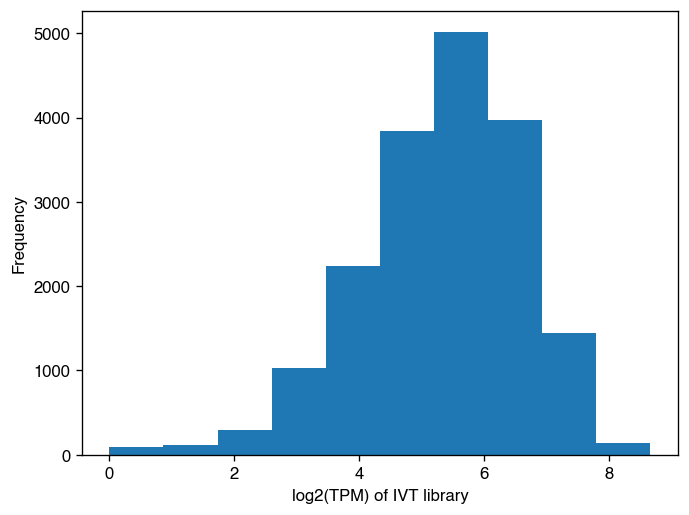

In [8]:
# Plot distribution
fig, ax = pyplot.subplots()
ax.hist(log2_lib_tpm_df[('library', numpy.nan)])
ax.set_xlabel('log2(TPM) of IVT library')
ax.set_ylabel('Frequency')

# Load and preprocess TPM data

In [9]:
# Load file
tpm_df = pandas.read_csv('tpm_data_all_samples.tsv', sep='\t', index_col=0)

# Only retain UMI-deduplicated values
tpm_cols = tpm_df.columns.tolist()
tpm_cols = [c for c in tpm_cols if c[:4]=='TPM_']
tpm_df = tpm_df[tpm_cols]

tpm_df

,TPM_mapped_input_2hpf_repA,TPM_mapped_input_2hpf_repB,TPM_mapped_input_2hpf_repC,TPM_mapped_frac1_2hpf_repA,TPM_mapped_frac1_2hpf_repB,TPM_mapped_frac1_2hpf_repC,TPM_mapped_frac2_2hpf_repA,TPM_mapped_frac2_2hpf_repB,TPM_mapped_frac2_2hpf_repC,TPM_mapped_frac3_2hpf_repA,...,TPM_mapped_input_10hpf_repC,TPM_mapped_frac1_10hpf_repA,TPM_mapped_frac1_10hpf_repB,TPM_mapped_frac1_10hpf_repC,TPM_mapped_frac2_10hpf_repA,TPM_mapped_frac2_10hpf_repB,TPM_mapped_frac2_10hpf_repC,TPM_mapped_frac3_10hpf_repA,TPM_mapped_frac3_10hpf_repB,TPM_mapped_frac3_10hpf_repC
insert_id,,,,,,,,,,,,,,,,,,,,,
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,171.146495,201.114752,210.049338,221.606150,212.378930,214.481189,92.888872,96.090673,99.731641,61.664448,...,147.312122,191.441468,250.770023,184.583434,56.032806,116.952629,82.933503,52.747412,40.851123,41.737711
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,97.959820,90.685908,112.749877,55.329010,56.114138,44.249196,35.854400,34.452093,47.921968,59.400849,...,94.316457,69.627556,76.402271,72.712279,35.067928,29.542186,50.479323,31.334690,15.944171,19.739347
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,64.030714,48.272061,43.130988,38.119199,19.933327,21.143461,15.032291,20.513721,23.605636,29.974065,...,66.394997,33.598089,11.367812,17.254783,19.344269,7.243603,22.813465,24.197116,40.851123,26.257381
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,67.674108,80.805719,83.688486,50.773472,42.757065,44.841650,64.597963,68.833412,91.666927,109.200022,...,132.341076,97.936423,79.229856,78.449261,112.563104,89.302387,93.574218,94.680660,143.799857,79.216405
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,81.974429,74.801185,86.610681,55.666457,44.313229,39.509558,65.276945,80.758463,62.829468,45.366536,...,93.214294,83.353067,105.620651,148.249213,63.145890,58.976314,50.479323,24.197116,14.283708,22.590987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSDARG00000005482_ENSDART00000169300_4321_rapgef2_17462.3,63.028781,57.005929,63.618465,37.275581,23.823737,29.042857,22.501091,26.398812,33.014468,27.257746,...,61.618958,64.480489,40.586192,47.852022,44.052876,37.569675,53.139502,12.598558,24.246488,17.702462
ENSDARG00000037178_ENSDART00000054066_201_zic2b_19629.1,86.893011,83.753400,86.482233,74.226057,48.203638,49.778773,77.724945,88.966616,98.020944,63.928047,...,104.052229,58.475578,81.114913,89.923226,42.181012,45.597165,62.716145,32.226887,22.586025,35.423366
ENSDARG00000037178_ENSDART00000054066_201_zic2b_19629.2,28.780878,20.214510,30.543071,16.016403,11.633787,11.071730,24.538036,23.611137,29.837459,32.237663,...,37.371375,24.161800,23.620681,24.904093,26.082980,21.514696,29.197894,17.951738,7.641854,22.998364


In [10]:
# Make multiindex version of TPM dataframe
tpm_mi_df = tpm_df.copy()
tpm_cols = tpm_mi_df.columns.str.extract("^TPM_mapped_([a-zA-Z0-9]+)_(\d+)hpf_rep([ABC])$")
tpm_cols[1] = tpm_cols[1].astype(int)
tpm_cols.replace({'frac1': '80S', 'frac2': 'LMW', 'frac3': 'HMW', 'input': 'total'}, inplace=True)
tpm_mi_df.columns = pandas.MultiIndex.from_frame(
    tpm_cols,
    names=['fraction', 'timepoint', 'replicate'],
)
tpm_mi_df = tpm_mi_df.loc[metadata_df.index]
tpm_mi_df

fraction                                                 total              \
timepoint                                                   2                
replicate                                                    A           B   
insert_id                                                                    
ENSDARG00000000001_ENSDART00000000004_19058_slc...  171.146495  201.114752   
ENSDARG00000000018_ENSDART00000181044_14421_nrf...   97.959820   90.685908   
ENSDARG00000000019_ENSDART00000124452_14118_ube...   64.030714   48.272061   
ENSDARG00000000068_ENSDART00000000069_2438_slc9...   67.674108   80.805719   
ENSDARG00000000069_ENSDART00000000070_12170_dap...   81.974429   74.801185   
...                                                        ...         ...   
ENSDARG00000025554_ENSDART00000103273_1746_wdr8...    1.910848    1.545867   
ENSDARG00000103318_ENSDART00000161570_7325_mrpl...    1.728679    1.764213   
ENSDARG00000036698_ENSDART00000053300_7697_znf8...    2.821697    1.600453   
ENSDARG00000056892_ENSDART00000148517_5556_mpp6...    4.552309    1.545867   
ENSDARG00000060768_ENSDART00000133628_7544_anki...    1.728679    1.764213   

fraction                                                               80S  \
timepoint                                                               2    
replicate                                                    C           A   
insert_id                                                                    
ENSDARG00000000001_ENSDART00000000004_19058_slc...  210.049338  221.606150   
ENSDARG00000000018_ENSDART00000181044_14421_nrf...  112.749877   55.329010   
ENSDARG00000000019_ENSDART00000124452_14118_ube...   43.130988   38.119199   
ENSDARG00000000068_ENSDART00000000069_2438_slc9...   83.688486   50.773472   
ENSDARG00000000069_ENSDART00000000070_12170_dap...   86.610681   55.666457   
...                                                        ...         ...   
ENSDARG00000025554_ENSDART00000103273_1746_wdr8...    2.220257    1.506171   
ENSDARG00000103318_ENSDART00000161570_7325_mrpl...    1.834913    1.674895   
ENSDARG00000036698_ENSDART00000053300_7697_znf8...    2.798274    1.674895   
ENSDARG00000056892_ENSDART00000148517_5556_mpp6...    3.247842    2.855960   
ENSDARG00000060768_ENSDART00000133628_7544_anki...    1.834913    2.181065   

fraction                                                                    \
timepoint                                                                    
replicate                                                    B           C   
insert_id                                                                    
ENSDARG00000000001_ENSDART00000000004_19058_slc...  212.378930  214.481189   
ENSDARG00000000018_ENSDART00000181044_14421_nrf...   56.114138   44.249196   
ENSDARG00000000019_ENSDART00000124452_14118_ube...   19.933327   21.143461   
ENSDARG00000000068_ENSDART00000000069_2438_slc9...   42.757065   44.841650   
ENSDARG00000000069_ENSDART00000000070_12170_dap...   44.313229   39.509558   
...                                                        ...         ...   
ENSDARG00000025554_ENSDART00000103273_1746_wdr8...    1.000000    1.789940   
ENSDARG00000103318_ENSDART00000161570_7325_mrpl...    1.518721    1.987425   
ENSDARG00000036698_ENSDART00000053300_7697_znf8...    1.518721    1.987425   
ENSDARG00000056892_ENSDART00000148517_5556_mpp6...    2.556164    1.394970   
ENSDARG00000060768_ENSDART00000133628_7544_anki...    1.000000    1.197485   

fraction                                                  LMW             \
timepoint                                                  2               
replicate                                                   A          B   
insert_id                                                                  
ENSDARG00000000001_ENSDART00000000004_19058_slc...  92.888872  96.090673   
ENSDARG00000000018_ENSDART00000181044_14421_nrf...  35.854400  34.452093   
ENSDARG00000000019_ENSDART00000

In [11]:
# Get geom mean TPM to append to summary table
tpm_gmean_df = numpy.exp(numpy.log(tpm_mi_df).groupby(level=[0, 1], axis=1).mean())
tpm_gmean_df

fraction                                                   80S              \
timepoint                                                   2           4    
insert_id                                                                    
ENSDARG00000000001_ENSDART00000000004_19058_slc...  216.119597  300.098846   
ENSDARG00000000018_ENSDART00000181044_14421_nrf...   51.599266   72.615184   
ENSDARG00000000019_ENSDART00000124452_14118_ube...   25.232864   28.564950   
ENSDARG00000000068_ENSDART00000000069_2438_slc9...   46.001865   50.122090   
ENSDARG00000000069_ENSDART00000000070_12170_dap...   46.019622   63.623896   
...                                                        ...         ...   
ENSDARG00000025554_ENSDART00000103273_1746_wdr8...    1.391781    2.147890   
ENSDARG00000103318_ENSDART00000161570_7325_mrpl...    1.716269    1.405241   
ENSDARG00000036698_ENSDART00000053300_7697_znf8...    1.716269    1.811403   
ENSDARG00000056892_ENSDART00000148517_5556_mpp6...    2.167547    2.470124   
ENSDARG00000060768_ENSDART00000133628_7544_anki...    1.377145    2.354843   

fraction                                                                    \
timepoint                                                   6           10   
insert_id                                                                    
ENSDARG00000000001_ENSDART00000000004_19058_slc...  344.106715  206.935398   
ENSDARG00000000018_ENSDART00000181044_14421_nrf...   66.370199   72.861548   
ENSDARG00000000019_ENSDART00000124452_14118_ube...   28.856285   18.748520   
ENSDARG00000000068_ENSDART00000000069_2438_slc9...   51.030345   84.750185   
ENSDARG00000000069_ENSDART00000000070_12170_dap...   82.644983  109.283419   
...                                                        ...         ...   
ENSDARG00000025554_ENSDART00000103273_1746_wdr8...    1.283261    1.992386   
ENSDARG00000103318_ENSDART00000161570_7325_mrpl...    2.204592    1.395169   
ENSDARG00000036698_ENSDART00000053300_7697_znf8...    2.652752    2.944101   
ENSDARG00000056892_ENSDART00000148517_5556_mpp6...    5.410523    4.709876   
ENSDARG00000060768_ENSDART00000133628_7544_anki...    2.083061    1.689749   

fraction                                                   HMW             \
timepoint                                                   2          4    
insert_id                                                                   
ENSDARG00000000001_ENSDART00000000004_19058_slc...   52.395790  55.702172   
ENSDARG00000000018_ENSDART00000181044_14421_nrf...   44.664956  54.740053   
ENSDARG00000000019_ENSDART00000124452_14118_ube...   26.113239  40.141316   
ENSDARG00000000068_ENSDART00000000069_2438_slc9...  100.220723  99.442134   
ENSDARG00000000069_ENSDART00000000070_12170_dap...   35.883390  42.745489   
...                                                        ...        ...   
ENSDARG00000025554_ENSDART00000103273_1746_wdr8...    1.132558   2.145362   
ENSDARG00000103318_ENSDART00000161570_7325_mrpl...    1.548860   2.081752   
ENSDARG00000036698_ENSDART00000053300_7697_znf8...    2.407357   2.832935   
ENSDARG00000056892_ENSDART00000148517_5556_mpp6...    2.613460   3.085654   
ENSDARG00000060768_ENSDART00000133628_7544_anki...    1.331040   1.797839   

fraction                                                                   \
timepoint                                                  6           10   
insert_id                                                                   
ENSDARG00000000001_ENSDART00000000004_19058_slc...  59.340141   44.803430   
ENSDARG00000000018_ENSDART00000181044_14421_nrf...  68.632506   21.444703   
ENSDARG00000000019_ENSDART00000124452_14118_ube...  34.204028   29.607813   
ENSDARG00000000068_ENSDART00000000069_2438_slc9...  83.137348  102.552193   
ENSDARG00000000069_ENSDART00000000070_12170_dap...  42.463992   19.838702   
...                                                       ...         ...   
ENSDARG00000025554_ENSDART00000103273_1746

In [12]:
# Get mean log2 TPM to append to summary table
log2_tpm_df = numpy.log2(tpm_mi_df).groupby(level=[0, 1], axis=1).mean()
log2_tpm_df

fraction                                                 80S            \
timepoint                                                 2         4    
insert_id                                                                
ENSDARG00000000001_ENSDART00000000004_19058_slc...  7.755686  8.229294   
ENSDARG00000000018_ENSDART00000181044_14421_nrf...  5.689279  6.182199   
ENSDARG00000000019_ENSDART00000124452_14118_ube...  4.657232  4.836174   
ENSDARG00000000068_ENSDART00000000069_2438_slc9...  5.523620  5.647375   
ENSDARG00000000069_ENSDART00000000070_12170_dap...  5.524177  5.991497   
...                                                      ...       ...   
ENSDARG00000025554_ENSDART00000103273_1746_wdr8...  0.476932  1.102920   
ENSDARG00000103318_ENSDART00000161570_7325_mrpl...  0.779276  0.490817   
ENSDARG00000036698_ENSDART00000053300_7697_znf8...  0.779276  0.857108   
ENSDARG00000056892_ENSDART00000148517_5556_mpp6...  1.116063  1.304583   
ENSDARG00000060768_ENSDART00000133628_7544_anki...  0.461680  1.235631   

fraction                                                                \
timepoint                                                 6         10   
insert_id                                                                
ENSDARG00000000001_ENSDART00000000004_19058_slc...  8.426712  7.693037   
ENSDARG00000000018_ENSDART00000181044_14421_nrf...  6.052464  6.187086   
ENSDARG00000000019_ENSDART00000124452_14118_ube...  4.850814  4.228705   
ENSDARG00000000068_ENSDART00000000069_2438_slc9...  5.673283  6.405145   
ENSDARG00000000069_ENSDART00000000070_12170_dap...  6.368855  6.771931   
...                                                      ...       ...   
ENSDARG00000025554_ENSDART00000103273_1746_wdr8...  0.359815  0.994497   
ENSDARG00000103318_ENSDART00000161570_7325_mrpl...  1.140512  0.480439   
ENSDARG00000036698_ENSDART00000053300_7697_znf8...  1.407490  1.557827   
ENSDARG00000056892_ENSDART00000148517_5556_mpp6...  2.435768  2.235689   
ENSDARG00000060768_ENSDART00000133628_7544_anki...  1.058705  0.756809   

fraction                                                 HMW            \
timepoint                                                 2         4    
insert_id                                                                
ENSDARG00000000001_ENSDART00000000004_19058_slc...  5.711379  5.799662   
ENSDARG00000000018_ENSDART00000181044_14421_nrf...  5.481071  5.774525   
ENSDARG00000000019_ENSDART00000124452_14118_ube...  4.706710  5.327016   
ENSDARG00000000068_ENSDART00000000069_2438_slc9...  6.647037  6.635785   
ENSDARG00000000069_ENSDART00000000070_12170_dap...  5.165244  5.417700   
...                                                      ...       ...   
ENSDARG00000025554_ENSDART00000103273_1746_wdr8...  0.179585  1.101221   
ENSDARG00000103318_ENSDART00000161570_7325_mrpl...  0.631207  1.057798   
ENSDARG00000036698_ENSDART00000053300_7697_znf8...  1.267450  1.502298   
ENSDARG00000056892_ENSDART00000148517_5556_mpp6...  1.385961  1.625576   
ENSDARG00000060768_ENSDART00000133628_7544_anki...  0.412554  0.846264   

fraction                                                                \
timepoint                                                 6         10   
insert_id                                                                
ENSDARG00000000001_ENSDART00000000004_19058_slc...  5.890936  5.485537   
ENSDARG00000000018_ENSDART00000181044_14421_nrf...  6.100820  4.422549   
ENSDARG00000000019_ENSDART00000124452_14118_ube...  5.096094  4.887906   
ENSDARG00000000068_ENSDART00000000069_2438_slc9...  6.377425  6.680215   
ENSDARG00000000069_ENSDART00000000070_12170_dap...  5.408168  4.310246   
...                                                      ...       ...   
ENSDARG00000025554_ENSDART00000103273_1746_wdr8...  0.611269  2.080953   
ENSDARG00000103318_ENSDART00000161570_7325_mrpl...  0.606482  0.383981   
ENSDARG00000036698_ENSDART00000053300_7697_znf8...  1.658320  0.000000   
E

In [13]:
# Merge log2 tpm and library tpm dataframes
log2_tpm_all_df = log2_tpm_df.merge(log2_lib_tpm_df, left_index=True, right_index=True)
display(log2_tpm_all_df)

fraction                                                 80S            \
timepoint                                               2.0       4.0    
insert_id                                                                
ENSDARG00000000001_ENSDART00000000004_19058_slc...  7.755686  8.229294   
ENSDARG00000000018_ENSDART00000181044_14421_nrf...  5.689279  6.182199   
ENSDARG00000000019_ENSDART00000124452_14118_ube...  4.657232  4.836174   
ENSDARG00000000068_ENSDART00000000069_2438_slc9...  5.523620  5.647375   
ENSDARG00000000069_ENSDART00000000070_12170_dap...  5.524177  5.991497   
...                                                      ...       ...   
ENSDARG00000025554_ENSDART00000103273_1746_wdr8...  0.476932  1.102920   
ENSDARG00000103318_ENSDART00000161570_7325_mrpl...  0.779276  0.490817   
ENSDARG00000036698_ENSDART00000053300_7697_znf8...  0.779276  0.857108   
ENSDARG00000056892_ENSDART00000148517_5556_mpp6...  1.116063  1.304583   
ENSDARG00000060768_ENSDART00000133628_7544_anki...  0.461680  1.235631   

fraction                                                                \
timepoint                                               6.0       10.0   
insert_id                                                                
ENSDARG00000000001_ENSDART00000000004_19058_slc...  8.426712  7.693037   
ENSDARG00000000018_ENSDART00000181044_14421_nrf...  6.052464  6.187086   
ENSDARG00000000019_ENSDART00000124452_14118_ube...  4.850814  4.228705   
ENSDARG00000000068_ENSDART00000000069_2438_slc9...  5.673283  6.405145   
ENSDARG00000000069_ENSDART00000000070_12170_dap...  6.368855  6.771931   
...                                                      ...       ...   
ENSDARG00000025554_ENSDART00000103273_1746_wdr8...  0.359815  0.994497   
ENSDARG00000103318_ENSDART00000161570_7325_mrpl...  1.140512  0.480439   
ENSDARG00000036698_ENSDART00000053300_7697_znf8...  1.407490  1.557827   
ENSDARG00000056892_ENSDART00000148517_5556_mpp6...  2.435768  2.235689   
ENSDARG00000060768_ENSDART00000133628_7544_anki...  1.058705  0.756809   

fraction                                                 HMW            \
timepoint                                               2.0       4.0    
insert_id                                                                
ENSDARG00000000001_ENSDART00000000004_19058_slc...  5.711379  5.799662   
ENSDARG00000000018_ENSDART00000181044_14421_nrf...  5.481071  5.774525   
ENSDARG00000000019_ENSDART00000124452_14118_ube...  4.706710  5.327016   
ENSDARG00000000068_ENSDART00000000069_2438_slc9...  6.647037  6.635785   
ENSDARG00000000069_ENSDART00000000070_12170_dap...  5.165244  5.417700   
...                                                      ...       ...   
ENSDARG00000025554_ENSDART00000103273_1746_wdr8...  0.179585  1.101221   
ENSDARG00000103318_ENSDART00000161570_7325_mrpl...  0.631207  1.057798   
ENSDARG00000036698_ENSDART00000053300_7697_znf8...  1.267450  1.502298   
ENSDARG00000056892_ENSDART00000148517_5556_mpp6...  1.385961  1.625576   
ENSDARG00000060768_ENSDART00000133628_7544_anki...  0.412554  0.846264   

fraction                                                                \
timepoint                                               6.0       10.0   
insert_id                                                                
ENSDARG00000000001_ENSDART00000000004_19058_slc...  5.890936  5.485537   
ENSDARG00000000018_ENSDART00000181044_14421_nrf...  6.100820  4.422549   
ENSDARG00000000019_ENSDART00000124452_14118_ube...  5.096094  4.887906   
ENSDARG00000000068_ENSDART00000000069_2438_slc9...  6.377425  6.680215   
ENSDARG00000000069_ENSDART00000000070_12170_dap...  5.408168  4.310246   
...                                                      ...       ...   
ENSDARG00000025554_ENSDART00000103273_1746_wdr8...  0.611269  2.080953   
ENSDARG00000103318_ENSDART00000161570_7325_mrpl...  0.606482  0.383981   
ENSDARG00000036698_ENSDART00000053300_7697_znf8...  1.658320  0.000000   
E

In [14]:
# Get delta logTPM with respect to previous timepoint
# for t = 2hpf, use library TPM as reference

delta_log2_tpm_df = pandas.DataFrame()
colnames = []
for t_idx in range(len(timepoint_list)):
    if t_idx==0:
        delta_log2_tpm_df = pandas.concat(
            (
                delta_log2_tpm_df,
                log2_tpm_df[('total', timepoint_list[t_idx])] - log2_lib_tpm_df[('library', numpy.nan)],
            ),
            axis=1,
        )
    else:
        delta_log2_tpm_df = pandas.concat(
            (
                delta_log2_tpm_df,
                log2_tpm_df[('total', timepoint_list[t_idx])] - log2_tpm_df[('total', timepoint_list[t_idx-1])],
            ),
            axis=1,
        )
    colnames.append(f"Δlog2_TPM_{timepoint_list[t_idx]}hpf")
delta_log2_tpm_df.columns = colnames
delta_log2_tpm_df

,Δlog2_TPM_2hpf,Δlog2_TPM_4hpf,Δlog2_TPM_6hpf,Δlog2_TPM_10hpf
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,0.577539,-0.101583,0.089120,-0.545807
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,0.302559,0.112158,-0.167388,-0.188555
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,-0.201178,-0.206685,0.147694,0.000714
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,-0.472570,0.205453,-0.102785,0.727747
ENSDARG00000000069_ENSDART00000000070_12170_dap_2002,-0.613936,-0.088152,0.967107,-0.388989
...,...,...,...,...
ENSDARG00000116871_ENSDART00000184738_13463_BX284638.2_34577.1,-0.088178,-0.191223,-0.745299,0.999829
ENSDARG00000116871_ENSDART00000184738_13463_BX284638.2_34577.2,NaN,NaN,NaN,NaN
ENSDARG00000117069_ENSDART00000183177_5856_CABZ01060373.1_29663,-0.615733,0.195626,-0.115825,0.472836
ENSDARG00000117089_ENSDART00000190839_10080_zgc:86839_102733,-0.371744,-0.117451,0.752717,-0.249253


# Estimate abundances by correcting Δlog2TPM

In [15]:
n_controls = 100
lib_tpm_threshold = 3

delta_log2_x_df = pandas.DataFrame(index=delta_log2_tpm_df.index)
log2_x_df = pandas.DataFrame(index=delta_log2_tpm_df.index)
for t_idx, t in enumerate(timepoint_list):
    data_controls = delta_log2_tpm_df[f'Δlog2_TPM_{t}hpf']
    
    # Filter controls by IVT library TPM.
    data_controls = data_controls.loc[lib_tpm_df[lib_tpm_df[('library', numpy.nan)] > 3].index]

    # Sort by value, keep top n_controls
    data_controls = data_controls.sort_values(ascending=False).head(n_controls)
    control_mean = data_controls.mean()

    delta_log2_x_df[f'Δlog2_X_{t}hpf'] = delta_log2_tpm_df[f'Δlog2_TPM_{t}hpf'] - control_mean
    log2_x_df[f'log2_X_{t}hpf'] = 0
    for t_j in timepoint_list[:t_idx+1]:
        log2_x_df[f'log2_X_{t}hpf'] += delta_log2_x_df[f'Δlog2_X_{t_j}hpf']

display(delta_log2_x_df)
display(log2_x_df)

,Δlog2_X_2hpf,Δlog2_X_4hpf,Δlog2_X_6hpf,Δlog2_X_10hpf
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,-1.518080,-0.622075,-1.865967,-1.666726
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,-1.793061,-0.408333,-2.122476,-1.309474
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,-2.296798,-0.727177,-1.807394,-1.120205
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,-2.568190,-0.315038,-2.057873,-0.393172
ENSDARG00000000069_ENSDART00000000070_12170_dap_2002,-2.709556,-0.608643,-0.987980,-1.509908
...,...,...,...,...
ENSDARG00000116871_ENSDART00000184738_13463_BX284638.2_34577.1,-2.183798,-0.711715,-2.700386,-0.121090
ENSDARG00000116871_ENSDART00000184738_13463_BX284638.2_34577.2,NaN,NaN,NaN,NaN
ENSDARG00000117069_ENSDART00000183177_5856_CABZ01060373.1_29663,-2.711353,-0.324865,-2.070913,-0.648083
ENSDARG00000117089_ENSDART00000190839_10080_zgc:86839_102733,-2.467364,-0.637942,-1.202371,-1.370172


,log2_X_2hpf,log2_X_4hpf,log2_X_6hpf,log2_X_10hpf
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,-1.518080,-2.140155,-4.006122,-5.672848
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,-1.793061,-2.201394,-4.323870,-5.633343
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,-2.296798,-3.023975,-4.831368,-5.951573
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,-2.568190,-2.883228,-4.941101,-5.334272
ENSDARG00000000069_ENSDART00000000070_12170_dap_2002,-2.709556,-3.318199,-4.306180,-5.816088
...,...,...,...,...
ENSDARG00000116871_ENSDART00000184738_13463_BX284638.2_34577.1,-2.183798,-2.895512,-5.595899,-5.716988
ENSDARG00000116871_ENSDART00000184738_13463_BX284638.2_34577.2,NaN,NaN,NaN,NaN
ENSDARG00000117069_ENSDART00000183177_5856_CABZ01060373.1_29663,-2.711353,-3.036219,-5.107131,-5.755214
ENSDARG00000117089_ENSDART00000190839_10080_zgc:86839_102733,-2.467364,-3.105306,-4.307677,-5.677849


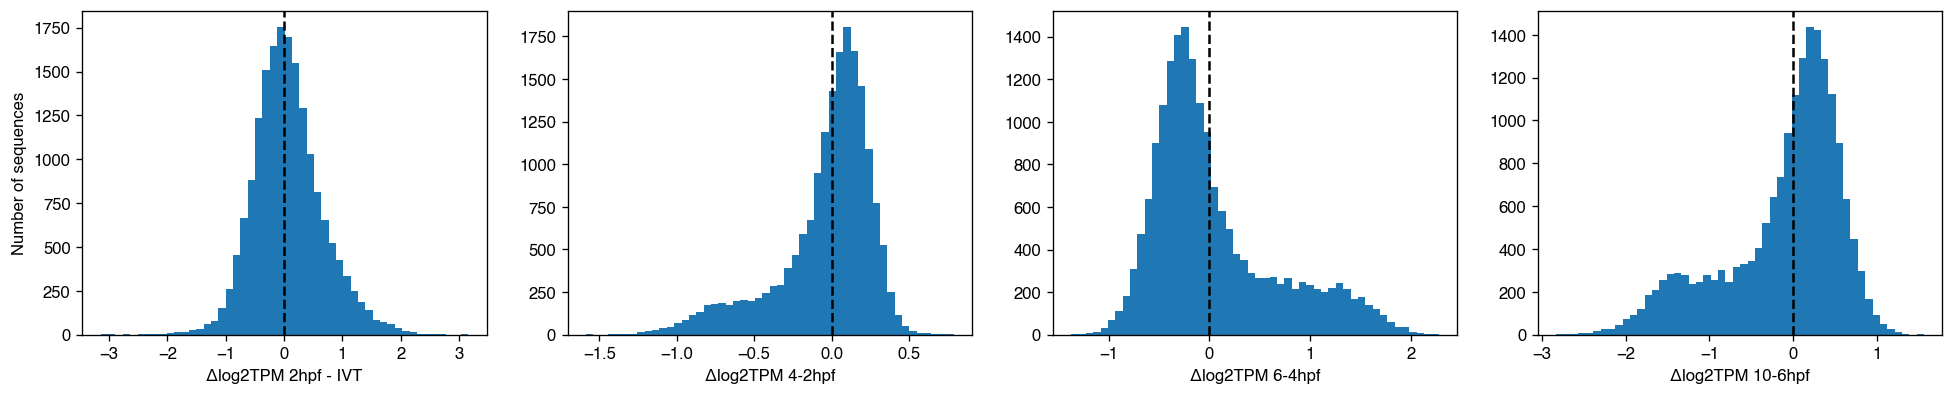

In [16]:
# histogram of initial log2 TPM
fig, axes = pyplot.subplots(1, len(timepoint_list), figsize=(5*len(timepoint_list), 3.5))

for t_idx, t in enumerate(timepoint_list):
    ax = axes[t_idx]
    ax.hist(delta_log2_tpm_df[f'Δlog2_TPM_{t}hpf'], bins=50)
    if t_idx == 0:
        ax.set_ylabel('Number of sequences')
        ax.set_xlabel(f'Δlog2TPM {t}hpf - IVT')
    else:
        ax.set_xlabel(f'Δlog2TPM {t}-{timepoint_list[t_idx-1]}hpf')
    ax.axvline(0, color='black', linestyle='--')

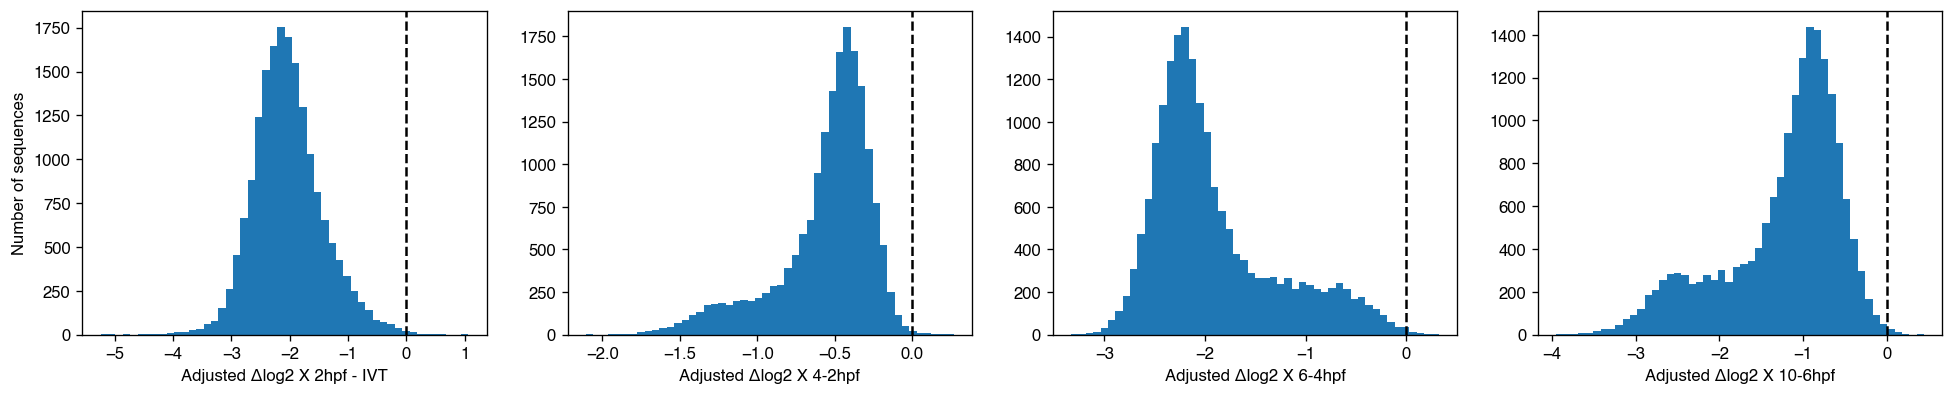

In [17]:
# histogram of adjusted log2 TPM
fig, axes = pyplot.subplots(1, len(timepoint_list), figsize=(5*len(timepoint_list), 3.5))

for t_idx, t in enumerate(timepoint_list):
    ax = axes[t_idx]
    ax.hist(delta_log2_x_df[f'Δlog2_X_{t}hpf'], bins=50)
    if t_idx == 0:
        ax.set_ylabel('Number of sequences')
        ax.set_xlabel(f'Adjusted Δlog2 X {t}hpf - IVT')
    else:
        ax.set_xlabel(f'Adjusted Δlog2 X {t}-{timepoint_list[t_idx-1]}hpf')
    ax.axvline(0, color='black', linestyle='--')

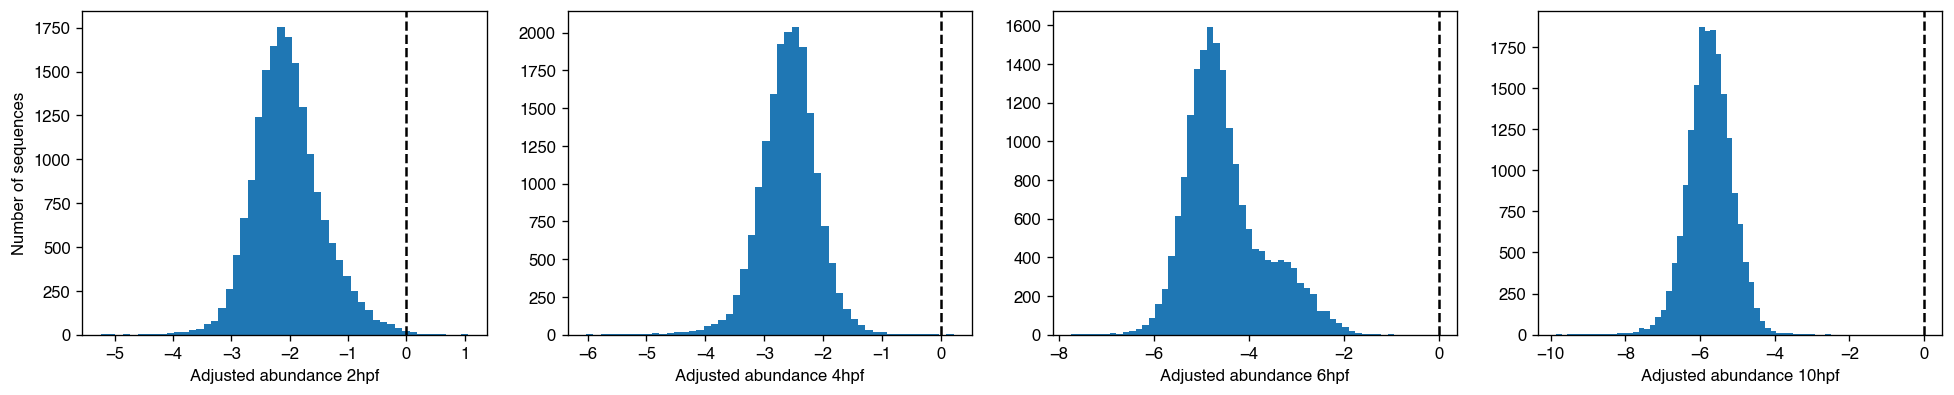

In [18]:
# histogram of adjusted abundance
fig, axes = pyplot.subplots(1, len(timepoint_list), figsize=(5*len(timepoint_list), 3.5))

for t_idx, t in enumerate(timepoint_list):
    ax = axes[t_idx]
    ax.hist(log2_x_df[f'log2_X_{t}hpf'], bins=50)
    ax.set_xlabel(f'Adjusted abundance {t}hpf')
    if t_idx == 0:
        ax.set_ylabel('Number of sequences')
    ax.axvline(0, color='black', linestyle='--')


# Calculate RRSs

In [19]:
log2_rrs_df = pandas.DataFrame(index=log2_tpm_df.index)

for p in pol_fraction_list:
    log2_rrs_fraction_df = log2_tpm_df[p] - log2_tpm_df['total']
    for t_idx, t in enumerate(timepoint_list):
        log2_rrs_df[f'log2_RRS_{p}_{t}hpf'] = log2_rrs_fraction_df[t]

log2_rrs_df

,log2_RRS_80S_2hpf,log2_RRS_80S_4hpf,log2_RRS_80S_6hpf,log2_RRS_80S_10hpf,log2_RRS_LMW_2hpf,log2_RRS_LMW_4hpf,log2_RRS_LMW_6hpf,log2_RRS_LMW_10hpf,log2_RRS_HMW_2hpf,log2_RRS_HMW_4hpf,log2_RRS_HMW_6hpf,log2_RRS_HMW_10hpf
insert_id,,,,,,,,,,,,
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,0.160504,0.735695,0.843993,0.656124,-1.007270,-0.442563,-0.357611,-0.686291,-1.883803,-1.693937,-1.691783,-1.551375
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,-0.955357,-0.574594,-0.536942,-0.213765,-1.360231,-1.246540,-0.830064,-1.176049,-1.163564,-0.982269,-0.488586,-1.978301
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,-1.017588,-0.631961,-0.765016,-1.387838,-1.398297,-0.461741,-1.263377,-1.735758,-0.968111,-0.141119,-0.519735,-0.728637
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,-0.744338,-0.826037,-0.697343,-0.693229,-0.055697,-0.333803,-0.347169,-0.483955,0.379079,0.162374,0.006799,-0.418159
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,-0.815344,-0.452308,0.110736,0.193902,-0.227051,-0.586062,-0.161769,-0.737928,-1.174277,-1.026105,-0.849952,-2.267783
...,...,...,...,...,...,...,...,...,...,...,...,...
ENSDARG00000025554_ENSDART00000103273_1746_wdr83os_27060,-0.427520,0.196392,-0.935567,0.007741,-0.053635,-0.086276,-0.439307,-0.833832,-0.724867,0.194694,-0.684112,1.094197
ENSDARG00000103318_ENSDART00000161570_7325_mrpl3_86762,-0.048860,-0.581917,-0.202008,-0.021005,-0.123899,-0.508786,-0.432059,0.319400,-0.196929,-0.014936,-0.736038,-0.117464
ENSDARG00000036698_ENSDART00000053300_7697_znf865_21263.6,-0.440584,-0.139434,0.189466,0.286796,0.445515,1.014863,0.541481,-0.462986,0.047590,0.505756,0.440297,-1.271031


# Estimate MRL

In [20]:
# The following values are "estimated" (by eye) from the polysome profiles
pol_value_list = [1, 3.5, 8]

In [21]:
# Calculate MRL
mrl_df = pandas.DataFrame()

for timepoint in timepoint_list:
    mrl_timepoint_col = f'MRL_{timepoint}hpf'
    log2_mrl_timepoint_col = f'log2_MRL_{timepoint}hpf'
    
    mrl_timepoint_df = (tpm_gmean_df[pol_fraction_list].xs(timepoint, axis=1, level=1) / tpm_gmean_df['total'][[timepoint]].values * pol_value_list).sum(axis=1)

    mrl_df[mrl_timepoint_col] = mrl_timepoint_df
    mrl_df[log2_mrl_timepoint_col] = numpy.log2(mrl_timepoint_df)

mrl_df

,MRL_2hpf,log2_MRL_2hpf,MRL_4hpf,log2_MRL_4hpf,MRL_6hpf,log2_MRL_6hpf,MRL_10hpf,log2_MRL_10hpf
insert_id,,,,,,,,
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,5.026628,2.329591,6.713248,2.747011,7.002960,2.807965,6.480393,2.696081
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,5.450300,2.446336,6.196041,2.631347,8.359783,3.063465,4.441558,2.151066
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,5.911159,2.563441,10.441205,3.384216,7.626433,2.931009,6.260806,2.646348
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,14.368484,3.844836,12.294140,3.619899,11.405933,3.511713,9.108052,3.187143
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,7.103448,2.828519,6.990700,2.805437,8.646954,3.112192,4.903643,2.293854
...,...,...,...,...,...,...,...,...
ENSDARG00000025554_ENSDART00000103273_1746_wdr83os_27060,8.956233,3.162892,13.598507,3.765376,8.083156,3.014919,20.048542,4.325425
ENSDARG00000103318_ENSDART00000161570_7325_mrpl3_86762,11.157909,3.479995,11.045525,3.465390,8.266639,3.047301,12.727341,3.669859
ENSDARG00000036698_ENSDART00000053300_7697_znf865_21263.6,13.771432,3.783607,19.339298,4.273464,17.089539,4.095042,7.074025,2.822531


# Compile data and save

In [22]:
# Prepare library TPM df to append
lib_tpm_df_to_append = lib_tpm_df.copy()
lib_tpm_df_to_append.columns = [f'TPM_library']
display(lib_tpm_df_to_append)

# Prepare TPM gmean df to append
tpm_df_to_append = tpm_gmean_df.copy()
tpm_df_to_append.columns = [f'TPM_{fraction}_{timepoint}hpf' for fraction, timepoint in tpm_df_to_append.columns]
display(tpm_df_to_append)

# Prepare log2 library TPM to append
log2_lib_tpm_df_to_append = log2_lib_tpm_df.copy()
log2_lib_tpm_df_to_append.columns = [f'log2_TPM_library']
display(log2_lib_tpm_df_to_append)

# Prepare mean log2 total TPM
log2_tpm_df_to_append = log2_tpm_df.copy()
log2_tpm_df_to_append.columns = [f'log2_TPM_{fraction}_{timepoint}hpf' for fraction, timepoint in log2_tpm_df_to_append.columns]
display(log2_tpm_df_to_append)

,TPM_library
insert_id,
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,129.574949
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,81.125109
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,58.728911
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,106.930406
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,84.534208
...,...
ENSDARG00000005482_ENSDART00000169300_4321_rapgef2_17462.3,63.244273
ENSDARG00000037178_ENSDART00000054066_201_zic2b_19629.1,103.611615
ENSDARG00000037178_ENSDART00000054066_201_zic2b_19629.2,48.907997


,TPM_80S_2hpf,TPM_80S_4hpf,TPM_80S_6hpf,TPM_80S_10hpf,TPM_HMW_2hpf,TPM_HMW_4hpf,TPM_HMW_6hpf,TPM_HMW_10hpf,TPM_LMW_2hpf,TPM_LMW_4hpf,TPM_LMW_6hpf,TPM_LMW_10hpf,TPM_total_2hpf,TPM_total_4hpf,TPM_total_6hpf,TPM_total_10hpf
insert_id,,,,,,,,,,,,,,,,
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,216.119597,300.098846,344.106715,206.935398,52.395790,55.702172,59.340141,44.803430,96.196505,132.609072,149.614766,81.607008,193.364948,180.217975,191.701721,131.317241
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,51.599266,72.615184,66.370199,72.861548,44.664956,54.740053,68.632506,21.444703,38.973036,45.577612,54.166972,37.395736,100.054038,108.142798,96.296120,84.498332
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,25.232864,28.564950,28.856285,18.748520,26.113239,40.141316,34.204028,29.607813,19.380357,32.142153,20.427659,14.731017,51.084741,44.266252,49.038036,49.062308
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,46.001865,50.122090,51.030345,84.750185,100.220723,99.442134,83.137348,102.552193,74.144157,70.502780,65.049109,97.980228,77.062564,88.856876,82.746495,137.032432
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,46.019622,63.623896,82.644983,109.283419,35.883390,42.745489,42.463992,19.838702,69.189005,57.990429,68.420218,57.285593,80.981555,87.051978,76.538821,95.539704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSDARG00000025554_ENSDART00000103273_1746_wdr83os_27060,1.391781,2.147890,1.283261,1.992386,1.132558,2.145362,1.527603,4.230865,1.803522,1.765713,1.810106,1.111821,1.871833,1.874528,2.454419,1.981724
ENSDARG00000103318_ENSDART00000161570_7325_mrpl3_86762,1.716269,1.405241,2.204592,1.395169,1.548860,2.081752,1.522542,1.304938,1.629282,1.478309,1.879646,1.766440,1.775389,2.103417,2.535939,1.415631
ENSDARG00000036698_ENSDART00000053300_7697_znf865_21263.6,1.716269,1.811403,2.652752,2.944101,2.407357,2.832935,3.156488,1.000000,3.171962,4.031745,3.385818,1.750837,2.329242,1.995212,2.326278,2.413340


,log2_TPM_library
insert_id,
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,7.017643
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,6.342077
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,5.875999
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,6.740528
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,6.401463
...,...
ENSDARG00000005482_ENSDART00000169300_4321_rapgef2_17462.3,5.982863
ENSDARG00000037178_ENSDART00000054066_201_zic2b_19629.1,6.695042
ENSDARG00000037178_ENSDART00000054066_201_zic2b_19629.2,5.611998


,log2_TPM_80S_2hpf,log2_TPM_80S_4hpf,log2_TPM_80S_6hpf,log2_TPM_80S_10hpf,log2_TPM_HMW_2hpf,log2_TPM_HMW_4hpf,log2_TPM_HMW_6hpf,log2_TPM_HMW_10hpf,log2_TPM_LMW_2hpf,log2_TPM_LMW_4hpf,log2_TPM_LMW_6hpf,log2_TPM_LMW_10hpf,log2_TPM_total_2hpf,log2_TPM_total_4hpf,log2_TPM_total_6hpf,log2_TPM_total_10hpf
insert_id,,,,,,,,,,,,,,,,
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,7.755686,8.229294,8.426712,7.693037,5.711379,5.799662,5.890936,5.485537,6.587913,7.051036,7.225109,6.350621,7.595182,7.493599,7.582719,7.036913
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,5.689279,6.182199,6.052464,6.187086,5.481071,5.774525,6.100820,4.422549,5.284404,5.510253,5.759342,5.224802,6.644636,6.756794,6.589406,6.400851
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,4.657232,4.836174,4.850814,4.228705,4.706710,5.327016,5.096094,4.887906,4.276523,5.006395,4.352452,3.880785,5.674821,5.468135,5.615829,5.616543
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,5.523620,5.647375,5.673283,6.405145,6.647037,6.635785,6.377425,6.680215,6.212261,6.139608,6.023457,6.614419,6.267958,6.473412,6.370626,7.098374
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,5.524177,5.991497,6.368855,6.771931,5.165244,5.417700,5.408168,4.310246,6.112471,5.857743,6.096351,5.840100,6.339521,6.443805,6.258120,6.578029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSDARG00000025554_ENSDART00000103273_1746_wdr83os_27060,0.476932,1.102920,0.359815,0.994497,0.179585,1.101221,0.611269,2.080953,0.850817,0.820251,0.856074,0.152924,0.904452,0.906528,1.295382,0.986756
ENSDARG00000103318_ENSDART00000161570_7325_mrpl3_86762,0.779276,0.490817,1.140512,0.480439,0.631207,1.057798,0.606482,0.383981,0.704236,0.563948,0.910461,0.820845,0.828135,1.072735,1.342520,0.501445
ENSDARG00000036698_ENSDART00000053300_7697_znf865_21263.6,0.779276,0.857108,1.407490,1.557827,1.267450,1.502298,1.658320,0.000000,1.665375,2.011404,1.759504,0.808045,1.219860,0.996542,1.218023,1.271031


In [23]:
# Compile data to save

# Start from summary table
df_to_save = metadata_df.copy()

# Add TPM, log2_TPM, input_diff_log2_TPM, MRL, log2_MRL
df_to_save = pandas.concat((df_to_save, lib_tpm_df_to_append), axis=1)
df_to_save = pandas.concat((df_to_save, tpm_df_to_append), axis=1)
df_to_save = pandas.concat((df_to_save, log2_lib_tpm_df_to_append), axis=1)
df_to_save = pandas.concat((df_to_save, log2_tpm_df_to_append), axis=1)
df_to_save = pandas.concat((df_to_save, delta_log2_tpm_df), axis=1)
df_to_save = pandas.concat((df_to_save, delta_log2_x_df), axis=1)
df_to_save = pandas.concat((df_to_save, log2_x_df), axis=1)
df_to_save = pandas.concat((df_to_save, log2_rrs_df), axis=1)
df_to_save = pandas.concat((df_to_save, mrl_df), axis=1)

# Filter out sequences with NaN in the first timepoint
df_to_save = df_to_save.loc[~pandas.isna(df_to_save['TPM_total_2hpf'])]

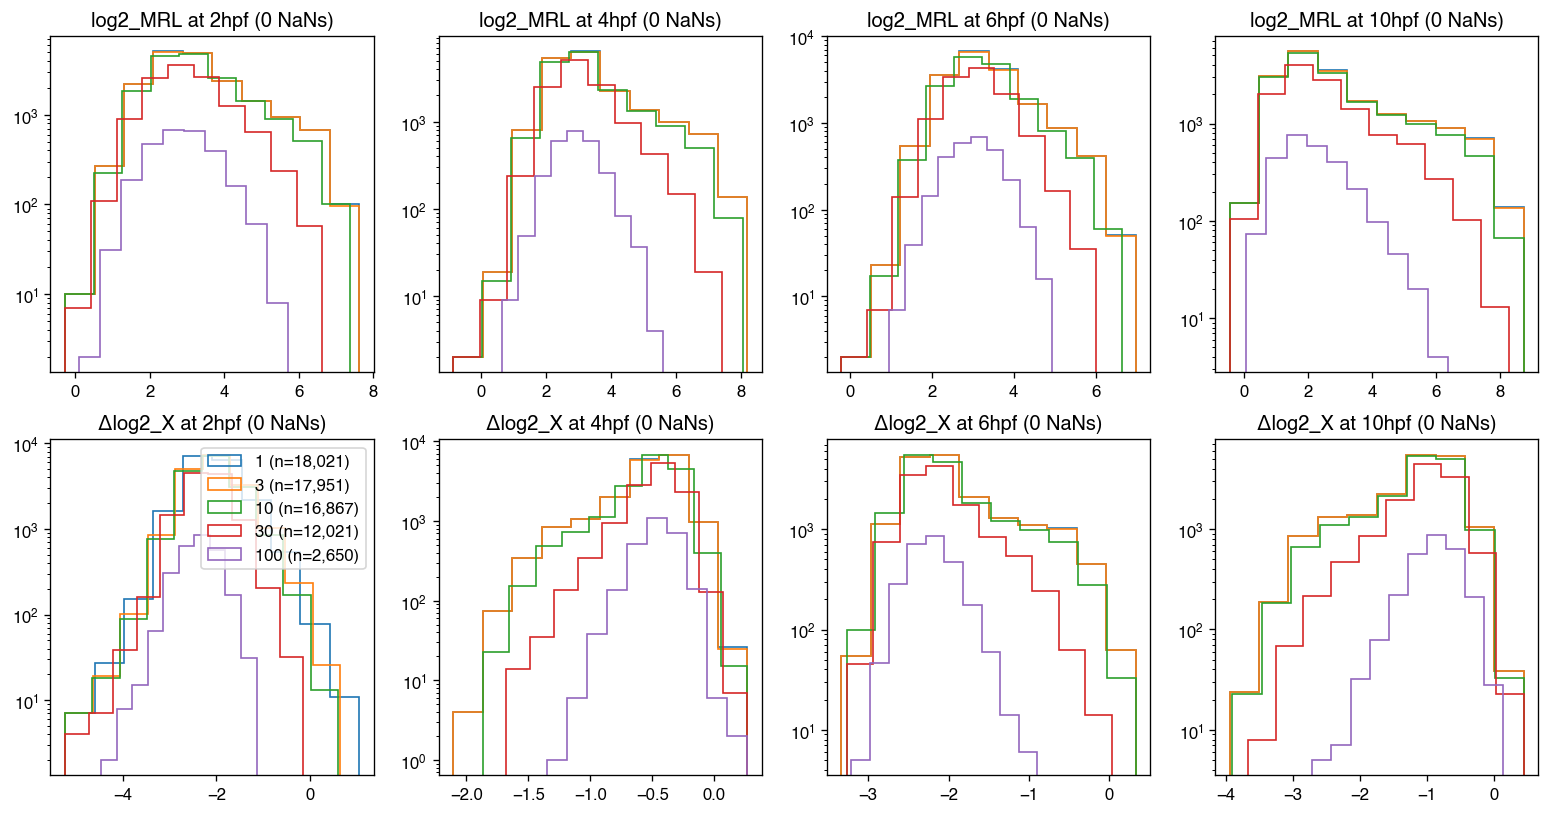

In [24]:
# Check the effect of tpm thresholding on MRL range
fig, axes = pyplot.subplots(
    2,
    len(timepoint_list),
    figsize=(4*len(timepoint_list), 4*2)
)
tpm_thresholds = [1, 3, 10, 30, 100]

for timepoint_idx in range(len(timepoint_list)):
    timepoint = timepoint_list[timepoint_idx]
    for tpm_threshold in tpm_thresholds:
        data_plot = df_to_save
        data_plot = data_plot[data_plot['TPM_library'] >= tpm_threshold]
        
        ax = axes[0, timepoint_idx]
        ax.hist(
            data_plot[f'log2_MRL_{timepoint}hpf'],
            histtype='step',
            label=f"{tpm_threshold} (n={len(data_plot):,})",
            log=True,
        )
        n_nans = data_plot[f'log2_MRL_{timepoint}hpf'].isna().sum()
        ax.set_title(f'log2_MRL at {timepoint}hpf ({n_nans} NaNs)')

        ax = axes[1, timepoint_idx]
        ax.hist(
            data_plot[f'Δlog2_X_{timepoint}hpf'],
            histtype='step',
            label=f"{tpm_threshold} (n={len(data_plot):,})",
            log=True,
        )
        n_nans = data_plot[f'Δlog2_X_{timepoint}hpf'].isna().sum()
        ax.set_title(f'Δlog2_X at {timepoint}hpf ({n_nans} NaNs)')
    if timepoint_idx==0:
        ax.legend()

In [25]:
df_to_save[df_to_save['TPM_library'] >= 3]

,chr,strand,external_gene_name,utr_length,insert_length,n_uORFs,GC_content,mxfold,index,index_base,...,log2_RRS_HMW_6hpf,log2_RRS_HMW_10hpf,MRL_2hpf,log2_MRL_2hpf,MRL_4hpf,log2_MRL_4hpf,MRL_6hpf,log2_MRL_6hpf,MRL_10hpf,log2_MRL_10hpf
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,chr9,-,slc35a5,103.0,103.0,2.0,52.427184,23.9,20318,20318,...,-1.691783,-1.551375,5.026628,2.329591,6.713248,2.747011,7.002960,2.807965,6.480393,2.696081
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,chr4,-,nrf1,134.0,134.0,0.0,61.940299,35.3,72681,72681,...,-0.488586,-1.978301,5.450300,2.446336,6.196041,2.631347,8.359783,3.063465,4.441558,2.151066
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,chr4,+,ube2h,178.0,178.0,1.0,46.629213,30.1,27446,27446,...,-0.519735,-0.728637,5.911159,2.563441,10.441205,3.384216,7.626433,2.931009,6.260806,2.646348
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,chr12,+,slc9a3r1a,152.0,152.0,0.0,46.052632,26.1,113092,113092,...,0.006799,-0.418159,14.368484,3.844836,12.294140,3.619899,11.405933,3.511713,9.108052,3.187143
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,chr24,-,dap,153.0,153.0,1.0,47.058824,31.8,20320,20320,...,-0.849952,-2.267783,7.103448,2.828519,6.990700,2.805437,8.646954,3.112192,4.903643,2.293854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSDARG00000060397_ENSDART00000085051_231_hhip_26758.1,chr1,+,hhip,410.0,209.0,2.0,31.578947,26.3,26758.1,26758,...,-1.105912,0.038826,8.498859,3.087269,8.491526,3.086024,5.599235,2.485230,10.805940,3.433753
ENSDARG00000098284_ENSDART00000170620_10459_ctxn1_29429.4,chr22,+,ctxn1,678.0,174.0,0.0,51.724138,41.2,29429.4,29429,...,0.562354,1.007008,17.148913,4.100045,17.061809,4.092699,17.786071,4.152676,24.531388,4.616557
ENSDARG00000103318_ENSDART00000161570_7325_mrpl3_86762,chr19,+,mrpl3,111.0,111.0,2.0,34.234234,12.5,86762,86762,...,-0.736038,-0.117464,11.157909,3.479995,11.045525,3.465390,8.266639,3.047301,12.727341,3.669859
ENSDARG00000036698_ENSDART00000053300_7697_znf865_21263.6,chr19,-,znf865,1305.0,197.0,4.0,31.979695,25.9,21263.6,21263,...,0.440297,-1.271031,13.771432,3.783607,19.339298,4.273464,17.089539,4.095042,7.074025,2.822531


In [26]:
# Save
df_to_save.to_csv('Zb_5UTR_MPRA_preprocessed.tsv.gz', sep='\t')
df_to_save

,chr,strand,external_gene_name,utr_length,insert_length,n_uORFs,GC_content,mxfold,index,index_base,...,log2_RRS_HMW_6hpf,log2_RRS_HMW_10hpf,MRL_2hpf,log2_MRL_2hpf,MRL_4hpf,log2_MRL_4hpf,MRL_6hpf,log2_MRL_6hpf,MRL_10hpf,log2_MRL_10hpf
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,chr9,-,slc35a5,103.0,103.0,2.0,52.427184,23.9,20318,20318,...,-1.691783,-1.551375,5.026628,2.329591,6.713248,2.747011,7.002960,2.807965,6.480393,2.696081
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,chr4,-,nrf1,134.0,134.0,0.0,61.940299,35.3,72681,72681,...,-0.488586,-1.978301,5.450300,2.446336,6.196041,2.631347,8.359783,3.063465,4.441558,2.151066
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,chr4,+,ube2h,178.0,178.0,1.0,46.629213,30.1,27446,27446,...,-0.519735,-0.728637,5.911159,2.563441,10.441205,3.384216,7.626433,2.931009,6.260806,2.646348
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,chr12,+,slc9a3r1a,152.0,152.0,0.0,46.052632,26.1,113092,113092,...,0.006799,-0.418159,14.368484,3.844836,12.294140,3.619899,11.405933,3.511713,9.108052,3.187143
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,chr24,-,dap,153.0,153.0,1.0,47.058824,31.8,20320,20320,...,-0.849952,-2.267783,7.103448,2.828519,6.990700,2.805437,8.646954,3.112192,4.903643,2.293854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSDARG00000025554_ENSDART00000103273_1746_wdr83os_27060,chr11,+,wdr83os,126.0,126.0,1.0,37.301587,22.8,27060,27060,...,-0.684112,1.094197,8.956233,3.162892,13.598507,3.765376,8.083156,3.014919,20.048542,4.325425
ENSDARG00000103318_ENSDART00000161570_7325_mrpl3_86762,chr19,+,mrpl3,111.0,111.0,2.0,34.234234,12.5,86762,86762,...,-0.736038,-0.117464,11.157909,3.479995,11.045525,3.465390,8.266639,3.047301,12.727341,3.669859
ENSDARG00000036698_ENSDART00000053300_7697_znf865_21263.6,chr19,-,znf865,1305.0,197.0,4.0,31.979695,25.9,21263.6,21263,...,0.440297,-1.271031,13.771432,3.783607,19.339298,4.273464,17.089539,4.095042,7.074025,2.822531
ENSDARG00000056892_ENSDART00000148517_5556_mpp6a_23746.2,chr16,-,mpp6a,311.0,161.0,1.0,39.130435,37.6,23746.2,23746,...,0.382270,-0.355217,13.484335,3.753213,14.144042,3.822123,19.909238,4.315366,16.071784,4.006458
